In [199]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification


In [200]:
cyclists_data = pd.read_csv("dataset/cyclists.csv",index_col=0)
races_data = pd.read_csv("dataset/races.csv",index_col=0)
cyclists_data.info()
# cyclists_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         6134 non-null   object 
 1   birth_year   6121 non-null   float64
 2   weight       3078 non-null   float64
 3   height       3143 non-null   float64
 4   nationality  6133 non-null   object 
 5   cyclist_id   6134 non-null   object 
dtypes: float64(3), object(3)
memory usage: 335.5+ KB


In [201]:
races_data.info()
# races_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 589865 entries, 0 to 589864
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _url                 589865 non-null  object 
 1   name                 589865 non-null  object 
 2   points               589388 non-null  float64
 3   uci_points           251086 non-null  float64
 4   length               589865 non-null  float64
 5   climb_total          442820 non-null  float64
 6   profile              441671 non-null  float64
 7   startlist_quality    589865 non-null  int64  
 8   average_temperature  29933 non-null   float64
 9   date                 589865 non-null  object 
 10  position             589865 non-null  int64  
 11  cyclist_age          589752 non-null  float64
 12  is_tarmac            589865 non-null  bool   
 13  is_cobbled           589865 non-null  bool   
 14  is_gravel            589865 non-null  bool   
 15  cyclist_team         4

# 1. Data Processing

## 1.1 Manage cyclists missing values and dataset merge

In [202]:
cyclists_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         6134 non-null   object 
 1   birth_year   6121 non-null   float64
 2   weight       3078 non-null   float64
 3   height       3143 non-null   float64
 4   nationality  6133 non-null   object 
 5   cyclist_id   6134 non-null   object 
dtypes: float64(3), object(3)
memory usage: 335.5+ KB


In [203]:
# We dont need name with id
cyclists_data = cyclists_data.drop(columns=['name'])

In [204]:
# Checkimg (and removing if there were any) duplicates in both datasets
duplicated_races = races_data[races_data.duplicated(keep=False)]
print(duplicated_races.shape)

duplicated_cyclists = cyclists_data[cyclists_data.duplicated(keep=False)]
print(duplicated_cyclists.shape)

(0, 18)
(0, 5)


In [205]:
# It has almost 100% of data loss, so we decided to drop it
races_data = races_data.drop(columns=['average_temperature'])

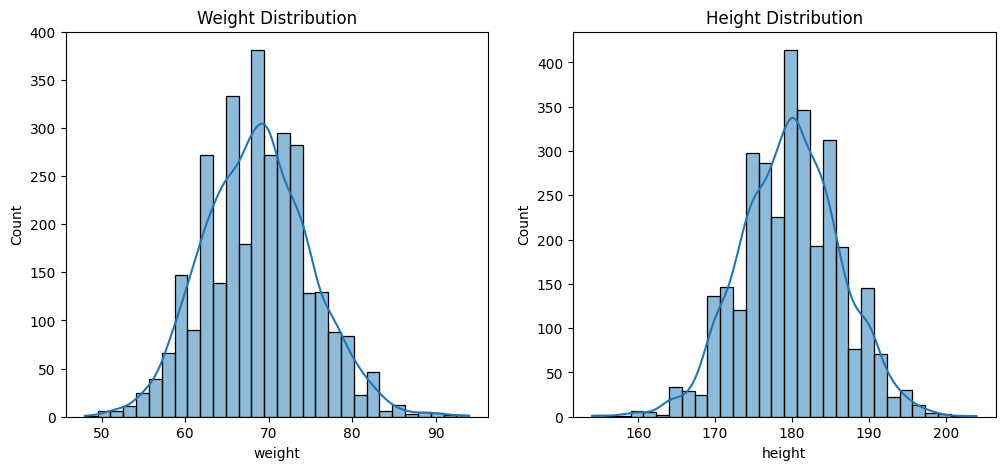

In [206]:
# Plotting distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(cyclists_data['weight'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Weight Distribution')

sns.histplot(cyclists_data['height'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Height Distribution')

plt.show()

In [207]:
# As is follows a normol distribution we can impute the mean
# Anyway lets create an imputed_weight and imputer_heigh columns
cyclists_data['imputed_weight'] = cyclists_data['weight'].isnull().astype(int)
cyclists_data['imputed_height'] = cyclists_data['height'].isnull().astype(int)

# Fill missing values with the mean of each column
cyclists_data['weight'].fillna(cyclists_data['weight'].mean(), inplace=True)
cyclists_data['height'].fillna(cyclists_data['height'].mean(), inplace=True)

C:\Users\angel\AppData\Local\Temp\ipykernel_11660\1691971542.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cyclists_data['weight'].fillna(cyclists_data['weight'].mean(), inplace=True)
C:\Users\angel\AppData\Local\Temp\ipykernel_11660\1691971542.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [208]:
cyclists_data.head()

,birth_year,weight,height,nationality,cyclist_id,imputed_weight,imputed_height
0,1964.0,68.658739,179.815145,Italy,bruno-surra,1,1
1,1965.0,74.000000,182.000000,France,gerard-rue,0,0
2,1996.0,69.000000,189.000000,Netherlands,jan-maas,0,0
3,1995.0,78.000000,192.000000,Belgium,nathan-van-hooydonck,0,0
4,1997.0,55.000000,171.000000,Spain,jose-felix-parra,0,0


In [209]:
races_data = races_data.rename(columns={"name": "race_name"})
cyclist_data = cyclists_data.rename(columns={"name": "cyclist_name"})

merged_df = races_data.merge(cyclist_data, on="cyclist_id", how="left")

# Mostrar las primeras filas para verificar
print(merged_df.head()) 

                          _url       race_name  points  uci_points    length  \
0  tour-de-france/1978/stage-6  Tour de France   100.0         NaN  162000.0   
1  tour-de-france/1978/stage-6  Tour de France   100.0         NaN  162000.0   
2  tour-de-france/1978/stage-6  Tour de France   100.0         NaN  162000.0   
3  tour-de-france/1978/stage-6  Tour de France   100.0         NaN  162000.0   
4  tour-de-france/1978/stage-6  Tour de France   100.0         NaN  162000.0   

   climb_total  profile  startlist_quality                 date  position  \
0       1101.0      1.0               1241  1978-07-05 04:02:24         0   
1       1101.0      1.0               1241  1978-07-05 04:02:24         1   
2       1101.0      1.0               1241  1978-07-05 04:02:24         2   
3       1101.0      1.0               1241  1978-07-05 04:02:24         3   
4       1101.0      1.0               1241  1978-07-05 04:02:24         4   

   ...  is_gravel                          cyclist_team 

## 1.2 Clean minimal missing values and create the splits

In [210]:
merged_df.isna().sum()

_url                      0
race_name                 0
points                  477
uci_points           338779
length                    0
climb_total          147045
profile              148194
startlist_quality         0
date                      0
position                  0
cyclist_age             113
is_tarmac                 0
is_cobbled                0
is_gravel                 0
cyclist_team         159161
delta                     0
cyclist_id                0
birth_year              113
weight                    0
height                    0
nationality              52
imputed_weight            0
imputed_height            0
dtype: int64

In [211]:
missing_percetages = (merged_df.isna().sum() / len(merged_df)) * 100
print(missing_percetages)

_url                  0.000000
race_name             0.000000
points                0.080866
uci_points           57.433311
length                0.000000
climb_total          24.928585
profile              25.123376
startlist_quality     0.000000
date                  0.000000
position              0.000000
cyclist_age           0.019157
is_tarmac             0.000000
is_cobbled            0.000000
is_gravel             0.000000
cyclist_team         26.982615
delta                 0.000000
cyclist_id            0.000000
birth_year            0.019157
weight                0.000000
height                0.000000
nationality           0.008816
imputed_weight        0.000000
imputed_height        0.000000
dtype: float64


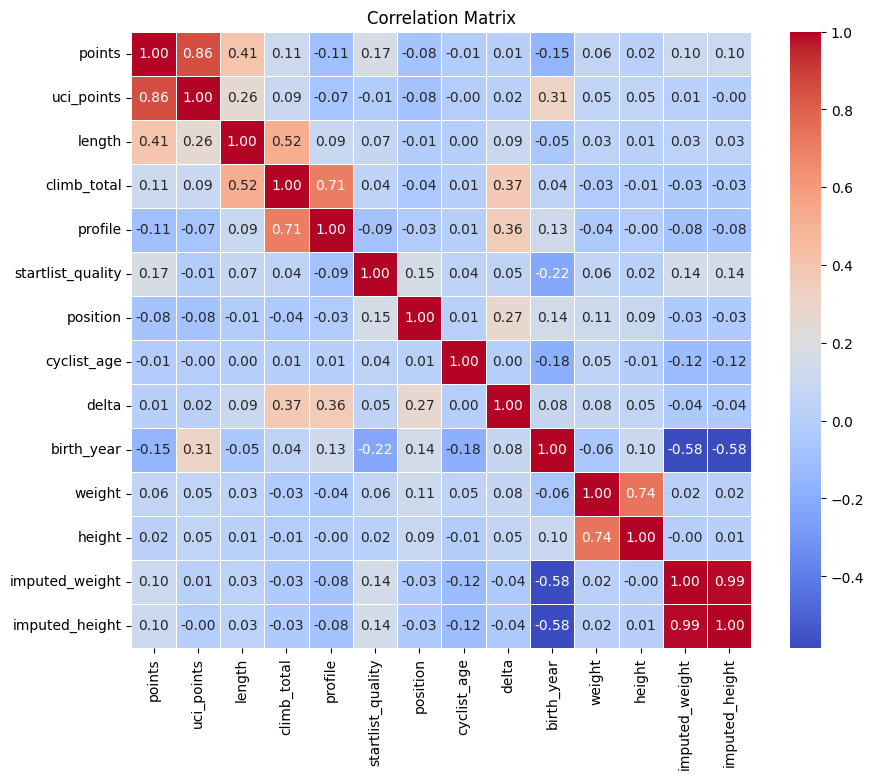

In [212]:
# Select only numerical columns
numerical_cols = merged_df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix for numerical columns
correlation_matrix = numerical_cols.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))  # Adjust the size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Title and show the plot
plt.title("Correlation Matrix")
plt.show()

In [213]:
## Combine profile and total and see if it has lower NAs
# climb_total and profile are highly correlated, so we combine them
merged_df['aug_profile'] = np.where(
    merged_df['climb_total'].notna() & merged_df['profile'].notna(),
    merged_df['climb_total'] / merged_df['climb_total'].max() + merged_df['profile'],
    np.nan  # Assign NaN if either column is still missing
)
merged_df = merged_df.drop(columns=['climb_total'])
merged_df = merged_df.drop(columns=['profile'])

missing_aug = (merged_df['aug_profile'].isna().sum() / len(merged_df)) * 100
print({missing_aug}, ' %')

{np.float64(30.646503861052953)}  %


In [214]:
# Uci points was used for first time in 2012, so it makes no sense to impute it. Remove or put 0
merged_df.drop('uci_points', axis=1)

,_url,race_name,points,length,startlist_quality,date,position,cyclist_age,is_tarmac,is_cobbled,...,cyclist_team,delta,cyclist_id,birth_year,weight,height,nationality,imputed_weight,imputed_height,aug_profile
0,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1241,1978-07-05 04:02:24,0,22.0,True,False,...,vini-ricordi-pinarello-sidermec-1986,0.0,sean-kelly,1956.0,77.000000,180.000000,Ireland,0,0,1.157872
1,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1241,1978-07-05 04:02:24,1,27.0,True,False,...,norway-1987,0.0,gerrie-knetemann,1951.0,68.658739,179.815145,Netherlands,1,1,1.157872
2,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1241,1978-07-05 04:02:24,2,24.0,True,False,...,NaN,0.0,rene-bittinger,1954.0,69.000000,174.000000,France,0,0,1.157872
3,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1241,1978-07-05 04:02:24,3,30.0,True,False,...,navigare-blue-storm-1993,0.0,joseph-bruyere,1948.0,68.658739,179.815145,Belgium,1,1,1.157872
4,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1241,1978-07-05 04:02:24,4,27.0,True,False,...,spain-1991,0.0,sven-ake-nilsson,1951.0,63.000000,172.000000,Sweden,0,0,1.157872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589860,giro-d-italia/2010/stage-1,Giro d'Italia,80.0,8400.0,878,2010-05-08 00:11:38,192,25.0,True,False,...,watney-avia-1972,80.0,anders-lund-1,1985.0,65.000000,167.000000,Denmark,0,0,1.008603
589861,giro-d-italia/2010/stage-1,Giro d'Italia,80.0,8400.0,878,2010-05-08 00:11:40,193,28.0,True,False,...,NaN,82.0,andrea-masciarelli,1982.0,61.000000,173.000000,Italy,0,0,1.008603
589862,giro-d-italia/2010/stage-1,Giro d'Italia,80.0,8400.0,878,2010-05-08 00:11:41,194,24.0,True,False,...,kazakhstan-2001,83.0,marco-corti,1986.0,59.000000,171.000000,Italy,0,0,1.008603
589863,giro-d-italia/2010/stage-1,Giro d'Italia,80.0,8400.0,878,2010-05-08 00:11:48,195,38.0,True,False,...,radio-popular-paredes-boavista-2023,90.0,robbie-mcewen,1972.0,67.000000,171.000000,Australia,0,0,1.008603


In [215]:
# As we have few missing values, drop rows if missing found in selected columns

merged_df = merged_df.dropna(subset=['points', 'cyclist_age', 'birth_year'])

### Create the splits

In [216]:
# Split _url into into ['race_name', 'year', 'stage'] by /
merged_df[['race_name', 'year', 'stage']] = merged_df['_url'].str.split('/', expand=True)
merged_df = merged_df.drop(columns=['_url'])
#merged_df['stage'] = merged_df['stage'].astype('string')
merged_df['year'] = merged_df['year'].astype(int)

In [217]:
merged_df['year'].max()

np.int64(2023)

In [218]:
# Define function to categorize 'position'
# This will later be the label for our classifiers
def categorize_position(pos):
    if pos <= 3:
        return "Podium"
    elif pos <= 20:
        return "Top20"
    elif pos <= 50:
        return "Top50"
    elif pos <= 100:
        return "Top100"
    else:
        return "Remaining"

# Apply categorization
merged_df["position_category"] = merged_df["position"].apply(categorize_position)

# Check distribution of categories
position_distribution = merged_df["position_category"].value_counts(normalize=True) * 100

position_distribution

position_category
Remaining    31.520767
Top100       31.311866
Top50        20.383692
Top20        13.206737
Podium        3.576938
Name: proportion, dtype: float64

In [219]:
#Lets use the most recent 10-15% of the rows for the test and a  similar distribution for the validation
test = merged_df[merged_df['year'] >= 2020]  # Los datos desde 2020 para el test
train_val = merged_df[merged_df['year'] < 2020]

# Buscamos un porcentaje parecido con val y test
train, validation = train_test_split(train_val, test_size=0.15, random_state=42)

test_percentage = (test.shape[0] / merged_df.shape[0]) * 100
val_percentage = (validation.shape[0] / merged_df.shape[0]) * 100
train_percentage = (train.shape[0] / merged_df.shape[0]) * 100

# Comparativa
print(f"Tamaño de train: {train.shape}. In percentage: {train_percentage}")
print(f"Tamaño de test: {test.shape}.   In percentage: {test_percentage}")
print(f"Tamaño de val: {validation.shape}.    In percentage: {val_percentage}")

Tamaño de train: (444860, 24). In percentage: 75.49276653514913
Tamaño de test: (65910, 24).   In percentage: 11.184930635102457
Tamaño de val: (78505, 24).    In percentage: 13.32230282974842


In [220]:
X_train = train.drop('position_category', axis=1)
y_train = train['position_category']

X_test = test.drop('position_category', axis=1)
y_test = test['position_category']

X_val = validation.drop('position_category', axis=1)
y_val = validation['position_category']

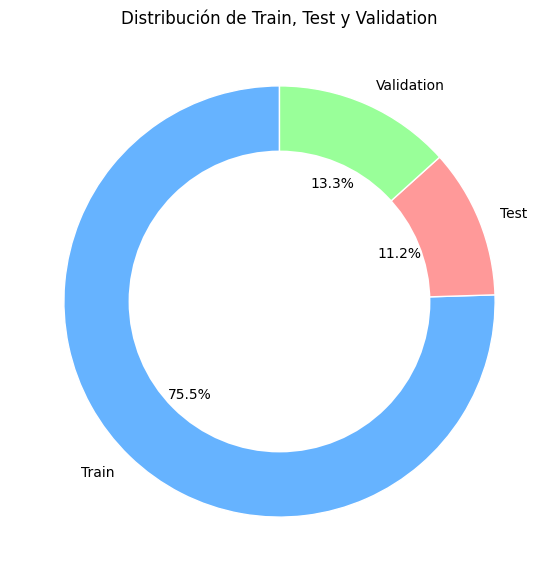

In [221]:
labels = ['Train', 'Test', 'Validation']
sizes = [train_percentage, test_percentage, val_percentage]
colors = ['#66b3ff', '#ff9999', '#99ff99']  # Colores para cada segmento

# Crear la figura y el gráfico de dona
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={'edgecolor': 'white'})

# Agregar un círculo en el centro para convertirlo en donut
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Título
plt.title("Distribución de Train, Test y Validation")
plt.show()

## 1.3 Missing values imputation by startegies comparisons

model = AdaBoostClassifier(n_estimators=100, random_state=0)
model.fit(X_val, y_val)
y_pred = model.predict([X_train])  # Example prediction
print(model.score(y_pred, y_test))  # Model accuracy

In [ ]:
merged_aug_tester = merged_df.copy()
merged_team_tester = merged_df.copy()

### Impute Aug_profile

In [ ]:
merged_aug_tester

### Impute Cyclists_team

## 1.4 Encode & Standarize

In [223]:
# Identify float64 columns
float_cols = races_data.select_dtypes(include=['float64']).columns

# Convert float64 to int, handling NaN values
for col in float_cols:
    if col in ['points', 'climb_total', 'uci_points', 'length', 'cyclist_age', 'delta']:  # Specify columns that should be int
        races_data[col] = races_data[col].fillna(0).astype(int)  # Replace NaN with 0 before conversion

# Check the new data types
print(races_data.dtypes)

_url                  object
race_name             object
points                 int64
uci_points             int64
length                 int64
climb_total            int64
profile              float64
startlist_quality      int64
date                  object
position               int64
cyclist_age            int64
is_tarmac               bool
is_cobbled              bool
is_gravel               bool
cyclist_team          object
delta                  int64
cyclist_id            object
dtype: object


In [224]:
# Nationality from object to category
cyclists_data['nationality'] = cyclists_data['nationality'].astype('category')

# Convert the 'cyclist_team' column to category type
races_data['cyclist_team'] = races_data['cyclist_team'].astype('category')
# Convert the 'cyclists_age' column to int32 type
races_data['cyclist_age'] = races_data['cyclist_age'].astype('int32')

# Correcting some type castings that are unnecesary in races dataset
races_data['points'] = races_data['points'].astype(int)
races_data['length'] = races_data['length'].astype(int)
races_data['delta'] = races_data['delta'].astype(int)
races_data['cyclist_age'] = races_data['cyclist_age'].astype(int)
races_data['cyclist_id'] = races_data['cyclist_id'].astype('string')

# Now we have 2 columns with race_name
races_data = races_data.drop(columns=['name'])

# Extract month from date and remove date
# Year already from _url and we discard day and hour
races_data['date'] = pd.to_datetime(races_data['date'])
races_data['month'] = races_data['date'].dt.month
races_data = races_data.drop(columns=['date'])

KeyError: "['name'] not found in axis"

In [ ]:
# Encode categorical values of races df
categorical_cols = ['cyclist_team', 'race_name', 'stage']
encoder = LabelEncoder()

for col in categorical_cols:
    races_data[col] = encoder.fit_transform(races_data[col])
    
cyclists_data['nationality'] = encoder.fit_transform(cyclists_data['nationality'])

In [ ]:
# Always: is_tarmac= true, is_cobbled=False, is_gravel=False
races_data = races_data.drop(columns=['is_tarmac', 'is_cobbled', 'is_gravel'])